# 1. INSTALL DEPENDENCIES

In [1]:
print("Installing dependencies with compatible versions...")

# Install in specific order to avoid conflicts
!pip install -q --no-cache-dir "numpy==1.26.4"
!pip install -q --no-cache-dir "pyarrow==14.0.1"
!pip install -q --no-cache-dir "transformers==4.44.0"
!pip install -q --no-cache-dir "datasets==2.14.0"
!pip install -q --no-cache-dir "albumentations"
!pip install -q --no-cache-dir "evaluate"
!pip install -q --no-cache-dir "pycocotools"
!pip install -q --no-cache-dir "Pillow"

print("\n✅ Dependencies installed!")

Installing dependencies with compatible versions...

✅ Dependencies installed!


# 2. IMPORTS

In [2]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cv2
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import (
    SegformerForSemanticSegmentation, 
    SegformerImageProcessor,
    TrainingArguments,
    Trainer
)

from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
import albumentations as A

import warnings
warnings.filterwarnings('ignore')

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2025-12-08 22:53:41.490519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765234421.511814     831 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765234421.518181     831 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla P100-PCIE-16GB


# 3. DATASET CONFIGURATIO

In [3]:
# Dataset paths
DATASET_PATH = "/kaggle/input/r2-v2-blackwalkers-medhack"
TRAIN_JSON = os.path.join(DATASET_PATH, "train/_annotations.coco.json")
VALID_JSON = os.path.join(DATASET_PATH, "valid/_annotations.coco.json")
TRAIN_IMAGES = os.path.join(DATASET_PATH, "train")
VALID_IMAGES = os.path.join(DATASET_PATH, "valid")

# Class mapping (ignore class 0 "objects", use classes 1-7)
id2label = {
    0: "background",  # We'll map everything to background initially
    1: "External Iliac Artery",
    2: "External Iliac Vein",
    3: "Obturator Nerve",
    4: "Ovary",
    5: "Ureter",
    6: "Uterine Artery",
    7: "Uterus"
}

label2id = {v: k for k, v in id2label.items()}
num_classes = len(id2label)

print(f"Number of classes: {num_classes}")
print(f"Class mapping:")
for class_id, label in id2label.items():
    print(f"  {class_id}: {label}")

Number of classes: 8
Class mapping:
  0: background
  1: External Iliac Artery
  2: External Iliac Vein
  3: Obturator Nerve
  4: Ovary
  5: Ureter
  6: Uterine Artery
  7: Uterus


# 4. LOAD AND ANALYZE COCO ANNOTATIONS

In [4]:
print("\n" + "="*60)
print("LOADING COCO ANNOTATIONS")
print("="*60)

# Load train annotations
print("\nLoading training annotations...")
coco_train = COCO(TRAIN_JSON)

# Load validation annotations
print("Loading validation annotations...")
coco_valid = COCO(VALID_JSON)

# Get statistics
train_img_ids = coco_train.getImgIds()
valid_img_ids = coco_valid.getImgIds()

print(f"\nDataset Statistics:")
print(f"  Training images: {len(train_img_ids)}")
print(f"  Validation images: {len(valid_img_ids)}")

# Analyze categories
categories = coco_train.loadCats(coco_train.getCatIds())
print(f"\nCategories in dataset:")
for cat in categories:
    print(f"  ID {cat['id']}: {cat['name']}")

# Count annotations per category
print(f"\nAnnotations per category (training):")
for cat in categories:
    if cat['id'] == 0:  # Skip "objects" class
        continue
    ann_ids = coco_train.getAnnIds(catIds=[cat['id']])
    print(f"  {cat['name']}: {len(ann_ids)} annotations")


LOADING COCO ANNOTATIONS

Loading training annotations...
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
Loading validation annotations...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

Dataset Statistics:
  Training images: 6420
  Validation images: 115

Categories in dataset:
  ID 0: objects
  ID 1: External Iliac Artery
  ID 2: External Iliac Vein
  ID 3: Obturator Nerve
  ID 4: Ovary
  ID 5: Ureter
  ID 6: Uterine Artery
  ID 7: uterus

Annotations per category (training):
  External Iliac Artery: 6310 annotations
  External Iliac Vein: 5080 annotations
  Obturator Nerve: 2320 annotations
  Ovary: 550 annotations
  Ureter: 350 annotations
  Uterine Artery: 2180 annotations
  uterus: 8580 annotations


# 5. COCO DATASET CLASS

In [5]:
class COCOSegmentationDataset(Dataset):
    """Dataset for COCO format segmentation"""
    
    def __init__(self, coco, img_dir, processor, target_size=512, augment=False):
        self.coco = coco
        self.img_dir = img_dir
        self.processor = processor
        self.target_size = target_size
        self.augment = augment
        self.img_ids = coco.getImgIds()
        
        # Augmentation pipeline
        if augment:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.GaussNoise(p=0.2),
            ])
        else:
            self.transform = None
    
    def __len__(self):
        return len(self.img_ids)
    
    def coco_to_mask(self, img_info, anns):
        """Convert COCO annotations to segmentation mask"""
        h, w = img_info['height'], img_info['width']
        mask = np.zeros((h, w), dtype=np.uint8)
        
        # Sort annotations by area (smaller objects on top)
        anns = sorted(anns, key=lambda x: x.get('area', 0), reverse=True)
        
        for ann in anns:
            cat_id = ann['category_id']
            
            # Skip class 0 ("objects")
            if cat_id == 0:
                continue
            
            # Convert COCO segmentation to mask
            if 'segmentation' in ann:
                if isinstance(ann['segmentation'], list):
                    # Polygon format
                    rles = coco_mask.frPyObjects(ann['segmentation'], h, w)
                    rle = coco_mask.merge(rles)
                elif isinstance(ann['segmentation']['counts'], list):
                    # Uncompressed RLE
                    rle = coco_mask.frPyObjects(ann['segmentation'], h, w)
                else:
                    # Compressed RLE
                    rle = ann['segmentation']
                
                m = coco_mask.decode(rle)
                mask[m > 0] = cat_id
        
        return mask
    
    def __getitem__(self, idx):
        # Load image info
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        # Load annotations and create mask
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = self.coco_to_mask(img_info, anns)
        
        # Apply augmentation
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        # Process image with SegFormer processor
        encoded = self.processor(
            images=image,
            return_tensors="pt"
        )
        
        # Resize mask to target size (nearest neighbor)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0).float()
        mask_resized = F.interpolate(
            mask_tensor, 
            size=(self.target_size, self.target_size), 
            mode="nearest"
        )
        mask_resized = mask_resized.squeeze(0).squeeze(0).long()
        
        # Prepare output
        encoded_inputs = {k: v.squeeze(0) for k, v in encoded.items()}
        encoded_inputs["labels"] = mask_resized
        
        return encoded_inputs


# 6. VISUALIZE SAMPLE ANNOTATIONS


VISUALIZING SAMPLE ANNOTATIONS


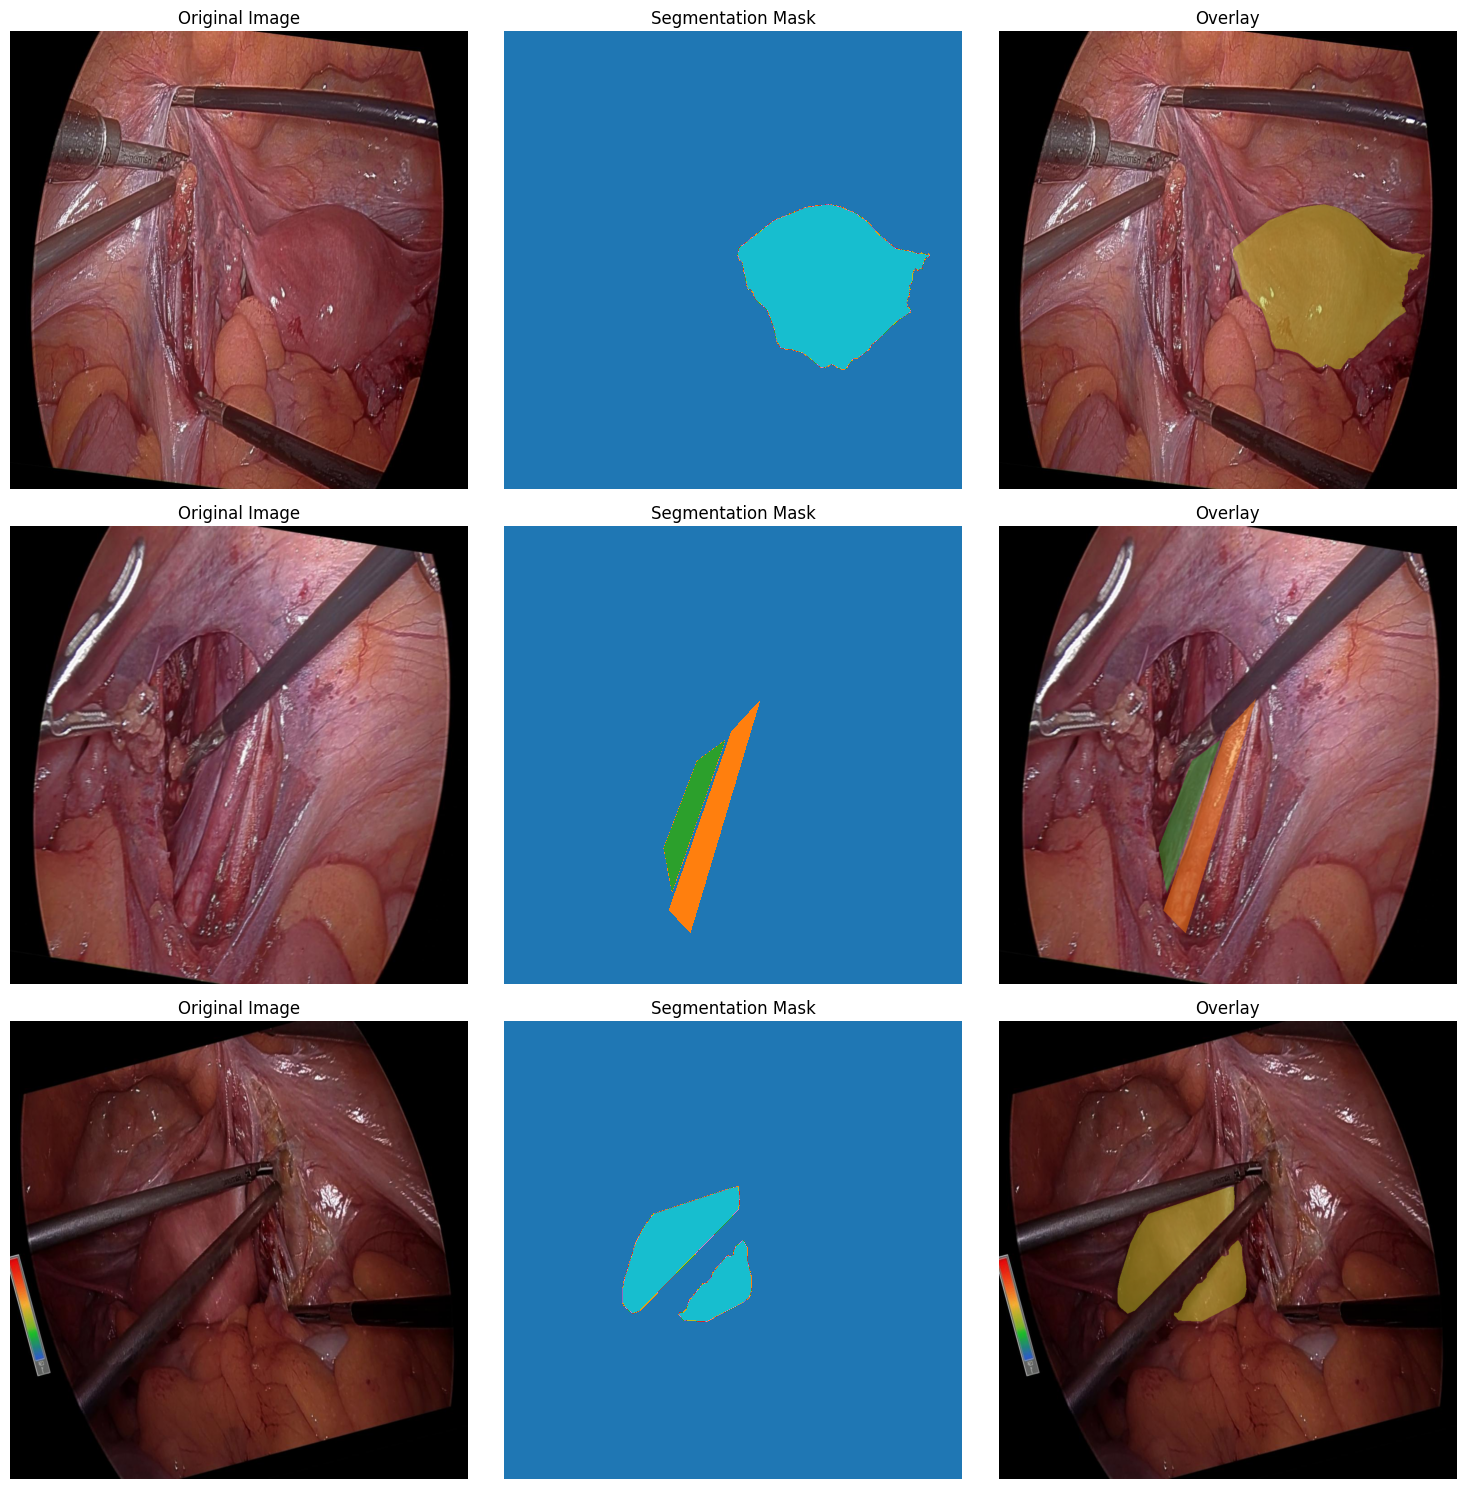


Class distribution in last visualized sample:
  Uterus: 45875 pixels (4.51%)


In [6]:
print("\n" + "="*60)
print("VISUALIZING SAMPLE ANNOTATIONS")
print("="*60)

import random  # make sure this is imported

def visualize_coco_samples(coco, img_dir, num_samples=3):
    """Visualize COCO annotations"""

    all_img_ids = coco.getImgIds()
    if len(all_img_ids) == 0:
        print("⚠️ No images found in COCO object.")
        return

    num_samples = min(num_samples, len(all_img_ids))
    # use Python's random instead of np.random.choice
    img_ids = random.sample(all_img_ids, num_samples)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    colors = plt.cm.get_cmap("tab10")

    last_mask = None  # for class distribution print

    for idx, img_id in enumerate(img_ids):
        # --- Load image info safely ---
        img_list = coco.loadImgs([int(img_id)])  # ALWAYS pass a list
        if len(img_list) == 0:
            print(f"⚠️ No img info for img_id={img_id}, skipping.")
            continue
        img_info = img_list[0]

        img_path = os.path.join(img_dir, img_info["file_name"])
        if not os.path.exists(img_path):
            print(f"⚠️ Image file not found: {img_path}, skipping.")
            continue

        img = Image.open(img_path).convert("RGB")
        img_array = np.array(img)

        # --- Load annotations ---
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        anns = coco.loadAnns(ann_ids)

        h, w = img_info["height"], img_info["width"]
        mask = np.zeros((h, w), dtype=np.uint8)

        for ann in anns:
            cat_id = ann["category_id"]
            if cat_id == 0:  # Skip generic "objects" class
                continue

            if "segmentation" in ann:
                seg = ann["segmentation"]
                if isinstance(seg, list):
                    # Polygon format
                    rles = coco_mask.frPyObjects(seg, h, w)
                    rle = coco_mask.merge(rles)
                elif isinstance(seg, dict) and isinstance(seg.get("counts", None), list):
                    # Uncompressed RLE
                    rle = coco_mask.frPyObjects(seg, h, w)
                else:
                    # Compressed RLE dict
                    rle = seg

                m = coco_mask.decode(rle)
                mask[m > 0] = cat_id

        # keep last mask for global stats print
        last_mask = mask

        # --- Plot original image ---
        axes[idx, 0].imshow(img_array)
        axes[idx, 0].set_title("Original Image")
        axes[idx, 0].axis("off")

        # --- Plot mask ---
        axes[idx, 1].imshow(mask, cmap="tab10", vmin=0, vmax=num_classes - 1)
        axes[idx, 1].set_title("Segmentation Mask")
        axes[idx, 1].axis("off")

        # --- Plot overlay ---
        overlay = img_array.copy().astype(float)
        for class_id in range(1, num_classes):
            mask_bool = mask == class_id
            if np.any(mask_bool):
                color = colors(class_id / num_classes)[:3]
                overlay[mask_bool] = (
                    overlay[mask_bool] * 0.5 + np.array(color) * 255 * 0.5
                )

        axes[idx, 2].imshow(overlay.astype(np.uint8))
        axes[idx, 2].set_title("Overlay")
        axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

    # Print simple class distribution from the last mask (just informational)
    if last_mask is not None:
        print("\nClass distribution in last visualized sample:")
        unique, counts = np.unique(last_mask, return_counts=True)
        for class_id, count in zip(unique, counts):
            if class_id == 0:
                continue
            class_name = id2label.get(class_id, f"class_{class_id}")
            percentage = (count / last_mask.size) * 100
            print(f"  {class_name}: {count} pixels ({percentage:.2f}%)")


# call it
visualize_coco_samples(coco_train, TRAIN_IMAGES, num_samples=3)

# 7. INITIALIZE MODEL AND PROCESSOR

In [7]:
MODEL_NAME = "nvidia/segformer-b1-finetuned-ade-512-512"

# Initialize processor
processor = SegformerImageProcessor.from_pretrained(MODEL_NAME)

# Initialize model
model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

print(f"✅ Model loaded: {MODEL_NAME}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.9M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([8, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded: nvidia/segformer-b1-finetuned-ade-512-512
Number of parameters: 13,679,304


# 8. CREATE DATASETS

Creating datasets...
✅ Datasets created:
  Train dataset: 6420 samples
  Val dataset: 115 samples

🔍 Testing dataset loading...
  pixel_values shape: torch.Size([3, 512, 512])
  labels shape: torch.Size([512, 512])
  labels unique values: [0, 7]
  labels min: 0, max: 7


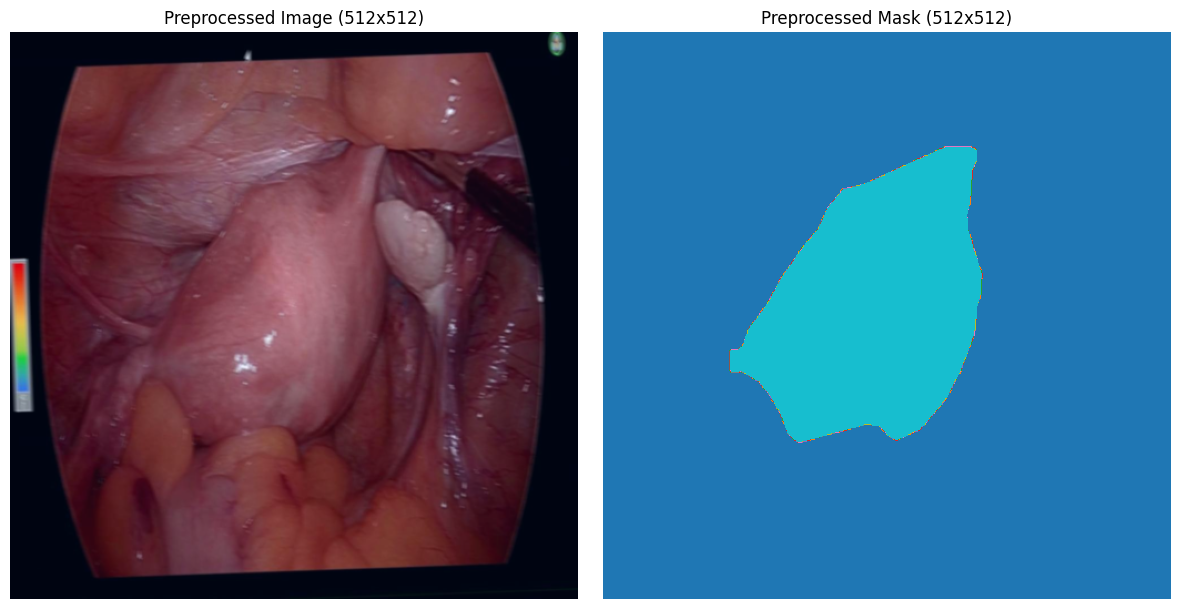

In [8]:
TARGET_SIZE = 512 

print("Creating datasets...")

train_dataset = COCOSegmentationDataset(
    coco_train,
    TRAIN_IMAGES,
    processor,
    target_size=TARGET_SIZE,
    augment=True
)

val_dataset = COCOSegmentationDataset(
    coco_valid,
    VALID_IMAGES,
    processor,
    target_size=TARGET_SIZE,
    augment=False
)

print(f"✅ Datasets created:")
print(f"  Train dataset: {len(train_dataset)} samples")
print(f"  Val dataset: {len(val_dataset)} samples")

# Test dataset loading
print("\n🔍 Testing dataset loading...")
sample = train_dataset[0]
print(f"  pixel_values shape: {sample['pixel_values'].shape}")
print(f"  labels shape: {sample['labels'].shape}")
print(f"  labels unique values: {torch.unique(sample['labels']).tolist()}")
print(f"  labels min: {sample['labels'].min().item()}, max: {sample['labels'].max().item()}")

# Visualize preprocessed sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

img = sample['pixel_values'].numpy().transpose(1, 2, 0)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

axes[0].imshow(img)
axes[0].set_title("Preprocessed Image (512x512)")
axes[0].axis('off')

axes[1].imshow(sample['labels'].numpy(), cmap='tab10', vmin=0, vmax=num_classes-1)
axes[1].set_title("Preprocessed Mask (512x512)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 9. METRICS

In [9]:
def compute_iou(preds, labels, num_classes):
    """Compute mean IoU"""
    ious = []
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        label_mask = (labels == cls)
        
        intersection = np.logical_and(pred_mask, label_mask).sum()
        union = np.logical_or(pred_mask, label_mask).sum()
        
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        ious.append(iou)
    
    return np.nanmean(ious)

def compute_dice(preds, labels, num_classes):
    """Compute mean Dice coefficient"""
    dices = []
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        label_mask = (labels == cls)
        
        intersection = np.logical_and(pred_mask, label_mask).sum()
        dice = (2. * intersection) / (pred_mask.sum() + label_mask.sum() + 1e-8)
        dices.append(dice)
    
    return np.mean(dices)

print("✅ Metric functions defined")

✅ Metric functions defined


# 10. TRAINING CONFIGURATION (DEBUG)

In [10]:
OUTPUT_DIR = "./segformer_b1"
BATCH_SIZE = 8  # Small batch for debug
NUM_EPOCHS = 30  # Just to verify everything works
LEARNING_RATE = 5e-5

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    logging_steps=10,
    logging_first_step=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_iou",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",
)

print("🔍 DEBUG Training Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS} (DEBUG - just to verify)")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Image size: {TARGET_SIZE}x{TARGET_SIZE}")
print(f"  FP16: {torch.cuda.is_available()}")

🔍 DEBUG Training Configuration:
  Model: nvidia/segformer-b1-finetuned-ade-512-512
  Batch size: 8
  Epochs: 30 (DEBUG - just to verify)
  Learning rate: 5e-05
  Image size: 512x512
  FP16: True


# 11. CUSTOM TRAINER

In [11]:
from transformers.trainer_utils import EvalLoopOutput

class SegmentationTrainer(Trainer):
    """Custom trainer with IoU/Dice metrics"""
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Don't mutate caller's dict
        labels = inputs["labels"]
        # forward pass
        outputs = model(pixel_values=inputs["pixel_values"])
        logits = outputs.logits
        
        # Upsample logits to match label size
        upsampled_logits = F.interpolate(
            logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        
        # Compute cross-entropy loss
        loss = F.cross_entropy(upsampled_logits, labels, ignore_index=255)
        
        return (loss, outputs) if return_outputs else loss
    
    def evaluation_loop(
        self,
        dataloader,
        description: str,
        prediction_loss_only: bool = None,
        ignore_keys = None,
        metric_key_prefix: str = "eval",
    ):
        model = self.model
        model.eval()
        
        total_loss = 0.0
        total_iou = 0.0
        total_dice = 0.0
        num_batches = 0
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc=description):
                pixel_values = batch["pixel_values"].to(model.device)
                labels = batch["labels"].to(model.device)

                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits

                # Upsample and compute loss
                upsampled_logits = F.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )
                loss = F.cross_entropy(upsampled_logits, labels, ignore_index=255)

                # Get predictions
                preds = upsampled_logits.argmax(dim=1)

                # Compute metrics
                iou = compute_iou(preds, labels, num_classes)
                dice = compute_dice(preds, labels, num_classes)

                total_loss += loss.item()
                total_iou += iou
                total_dice += dice
                num_batches += 1

        # Avoid division by zero just in case
        num_batches = max(num_batches, 1)

        metrics = {
            f"{metric_key_prefix}_loss": total_loss / num_batches,
            f"{metric_key_prefix}_iou":  total_iou / num_batches,
            f"{metric_key_prefix}_dice": total_dice / num_batches,
        }

        # Trainer expects EvalLoopOutput
        try:
            num_samples = len(dataloader.dataset)
        except TypeError:
            num_samples = num_batches * dataloader.batch_size

        return EvalLoopOutput(
            predictions=None,
            label_ids=None,
            metrics=metrics,
            num_samples=num_samples,
        )


# 12. TRAIN MODEL (DEBUG RUN)

In [12]:
trainer = SegmentationTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("\n" + "="*60)
print("🔍 STARTING DEBUG TRAINING (10 EPOCHS)")
print("="*60)
print("Purpose: Verify data loading, loss decreases, masks look good")
print("="*60 + "\n")

train_result = trainer.train()

print("\n" + "="*60)
print("✅ DEBUG TRAINING COMPLETED!")
print("="*60)



🔍 STARTING DEBUG TRAINING (10 EPOCHS)
Purpose: Verify data loading, loss decreases, masks look good



Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]


✅ DEBUG TRAINING COMPLETED!


# 13. SAVE DEBUG MODEL

In [13]:
trainer.save_model(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)

print(f"✅ Debug model saved to {OUTPUT_DIR}")

✅ Debug model saved to ./segformer_b1


# 14. VISUALIZE PREDICTIONS


VISUALIZING PREDICTIONS


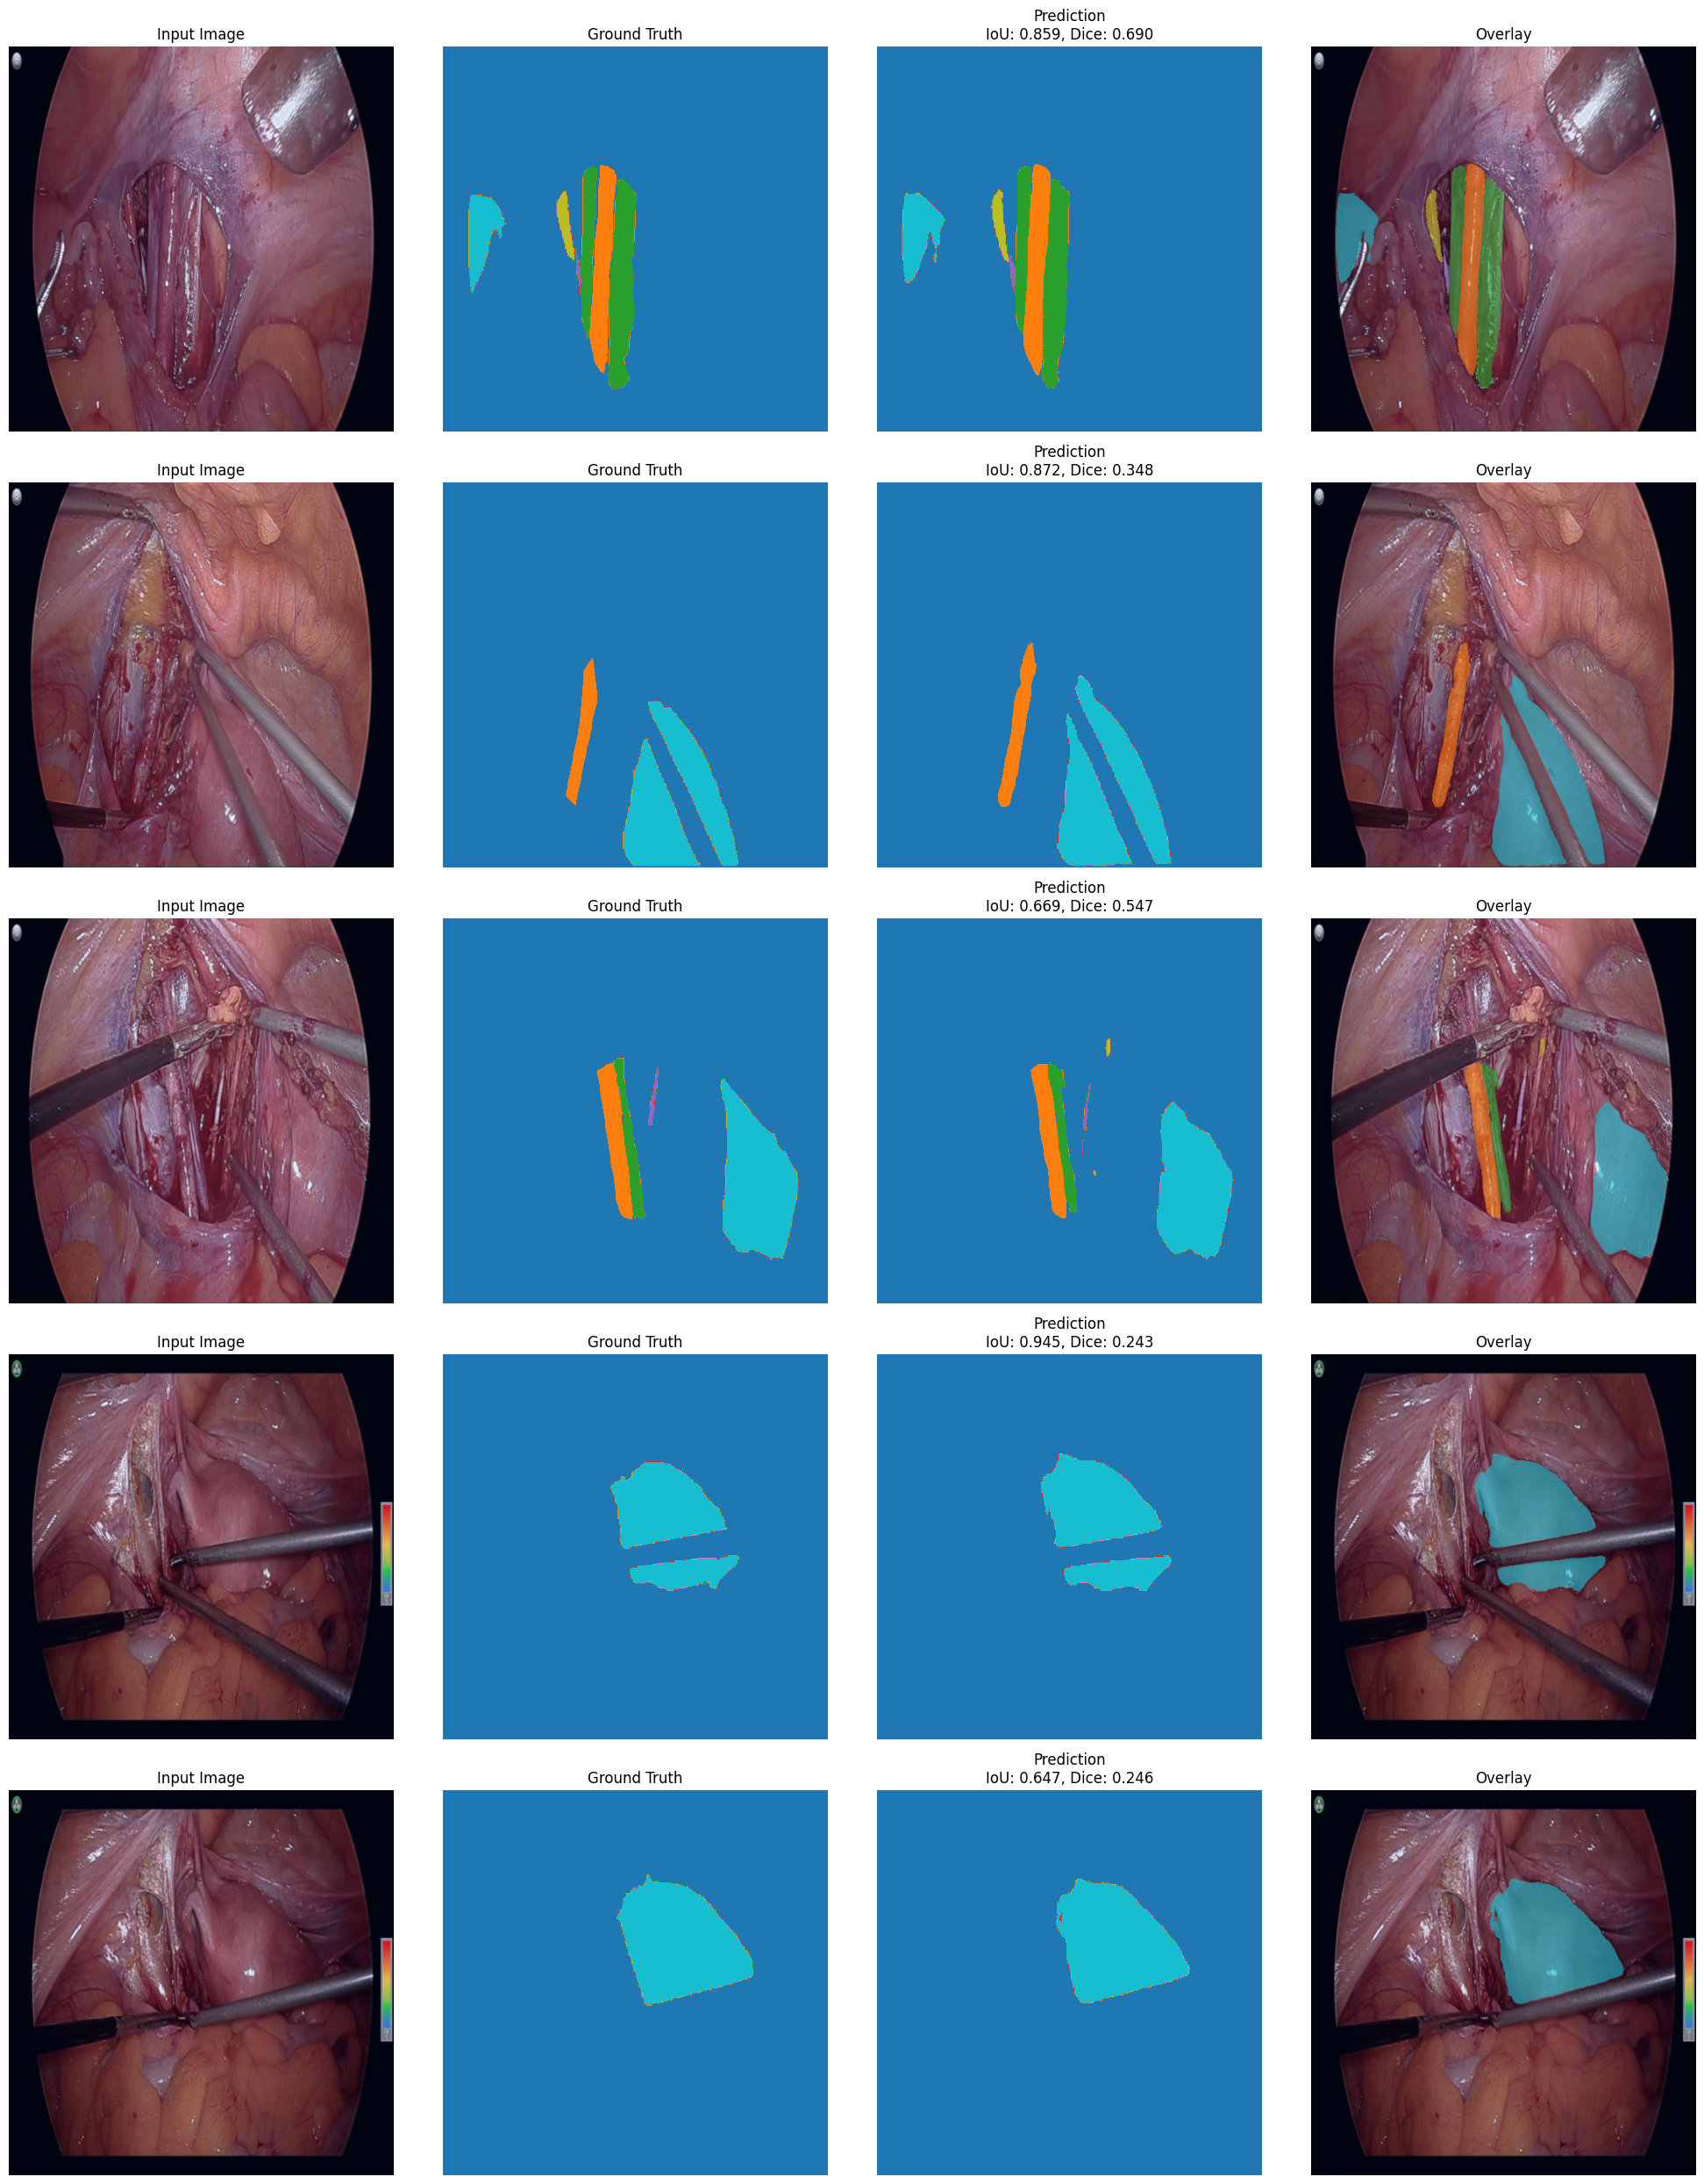

In [14]:
print("\n" + "="*60)
print("VISUALIZING PREDICTIONS")
print("="*60)

def visualize_predictions(model, dataset, num_samples=5):
    """Visualize model predictions"""
    model.eval()
    device = next(model.parameters()).device
    
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for idx, sample_idx in enumerate(indices):
            sample = dataset[sample_idx]
            pixel_values = sample["pixel_values"].unsqueeze(0).to(device)
            true_mask = sample["labels"]
            
            # Get prediction
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            # Upsample to original size
            upsampled_logits = F.interpolate(
                logits,
                size=true_mask.shape,
                mode="bilinear",
                align_corners=False
            )
            pred_mask = upsampled_logits.argmax(dim=1).squeeze().cpu()
            
            # Denormalize image
            img = pixel_values.squeeze().cpu().numpy().transpose(1, 2, 0)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            
            # Compute metrics
            sample_iou = compute_iou(pred_mask.unsqueeze(0), true_mask.unsqueeze(0), num_classes)
            sample_dice = compute_dice(pred_mask.unsqueeze(0), true_mask.unsqueeze(0), num_classes)
             
            # Plot
            axes[idx, 0].imshow(img)
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(true_mask, cmap='tab10', vmin=0, vmax=num_classes-1)
            axes[idx, 1].set_title("Ground Truth")
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(pred_mask, cmap='tab10', vmin=0, vmax=num_classes-1)
            axes[idx, 2].set_title(f"Prediction\nIoU: {sample_iou:.3f}, Dice: {sample_dice:.3f}")
            axes[idx, 2].axis('off')
            
            # Overlay
            img_uint8 = (img * 255).astype(np.uint8)
            overlay = img_uint8.copy()
            colors = plt.cm.tab10(np.linspace(0, 1, num_classes))
            
            for cls in range(1, num_classes):
                mask_bool = pred_mask.numpy() == cls
                if np.any(mask_bool):
                    color = colors[cls][:3] * 255
                    overlay[mask_bool] = (overlay[mask_bool] * 0.4 + color * 0.6).astype(np.uint8)
            
            axes[idx, 3].imshow(overlay)
            axes[idx, 3].set_title("Overlay")
            axes[idx, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset, num_samples=5)

In [15]:
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch

MODEL_DIR = "./segformer_b1"

processor = SegformerImageProcessor.from_pretrained(MODEL_DIR)
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_DIR)
model.eval()


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [16]:
dummy_input = torch.randn(1, 3, 512, 512) 

In [17]:
onnx_path = "segformer_model.onnx"

torch.onnx.export(
    model,
    (dummy_input,),
    onnx_path,
    input_names=["pixel_values"],
    output_names=["logits"],
    opset_version=17,
    dynamic_axes={
        "pixel_values": {0: "batch", 2: "height", 3: "width"},
        "logits": {0: "batch", 2: "height_out", 3: "width_out"}
    },
)

print("✅ ONNX model saved as:", onnx_path)


✅ ONNX model saved as: segformer_model.onnx
